# Purpose:

2015-03-13 (Friday)

Explore and characterize the results of the learned Beta filter method.

# Contents
[Loading-files](#Loading-files)

[Filtering-Stats](#Filtering-Stats)

[Characterization-of-contigs-with/without-regard-to-selected-SNP-pairs](#Characterization-of-contigs-with/without-regard-to-selected-SNP-pairs)
- [All-contigs](#All-contigs)
- [All-SNP-pair-contigs](#All-SNP-pair-contigs)
- [LD-filtered-SNP-pair-contigs](#LD-filtered-SNP-pair-contigs)

[Compare-with-Tajima's-D-results-from-AndreaG](#Compare-with-Tajima's-D-results-from-AndreaG)
- [Examine-ld_contig_taj_win_filter](#Examine-ld_contig_taj_win_filter)
- [Basic-summary-table-referencing-SNP-pairs](#Basic-summary-table-referencing-SNP-pairs)
- [How-is-q-value-related-to-SNP-pair-distance?](#How-is-q-value-related-to-SNP-pair-distance?)
- [What-is-the-distribution-of-SNPs-per-bin-used-for-Tajima's-D-bin_50](#What-is-the-distribution-of-SNPs-per-bin-used-for-Tajima's-D-bin_50)
- [How-Tajima's-D-score-bin_50-relate-to-number-of-SNPs-in-the-bin](#How-Tajima's-D-score-bin_50-relate-to-number-of-SNPs-in-the-bin)

[Average-LD-per-bin](#Average-LD-per-bin)
- [All-contigs-together](#All-contigs-together)
- [5-random-contigs](#5-random-contigs)
- 

## Imports:

In [1]:
import IPython

In [2]:
%%javascript
// IPython.load_extensions('python-markdown')
// IPython.html.nbextensions.check_nbextension('python-markdown')

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
# import tables as h5

import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm
import statsmodels.stats.multitest as smm

import munch

import pymc as mc

from spartan.utils.genome_specific.GfusI1 import GfusI1_0
from spartan.utils.fastas import ParseFastA

In [4]:
# set figure characteristics

# size
sns.set_context("talk")

# style
sns.set_style("whitegrid")

## File paths:

In [5]:
# define paths to files

base_out_dir = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/manuscript/figures/ld"

fasta_path = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/assemblies/GfusI1/Glossina-fuscipes-IAEA_SCAFFOLDS_GfusI1.fa"
contig_name_length_path = "/home/gus/Dropbox/uganda_data/data_repos/genome_info/assembly_info/contig_name_length.csv"

ld_results_pickle="/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/ld_thresholds/post_MAP_calc.plk"
tajimas_csv = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/Tajima50.csv"

# Record some info about the contigs once and for all

In [6]:
# contig_name_map = GfusI1_0.get_name_map_from_fasta_headers(fasta_path)

In [7]:
# contig_lengths = {}
# contigs = ParseFastA(fasta_path).to_dict()
# for name,seq in contigs.iteritems():
#     contig_lengths[name] = len(seq)

In [8]:
# # record both names and the length

# with open(contig_name_length_path,'w') as out:
#     template = "{kk_name},{scaf_name},{length}\n"
#     out.write(template.format(kk_name="kk_name",scaf_name="scaf_name",length="length"))
    
#     for kk_name, length in contig_lengths.iteritems():
#         out.write(template.format(kk_name=kk_name,
#                                   scaf_name=contig_name_map[kk_name],
#                                   length=length))
    

# Helper functions

In [9]:
def plot_bin_dists(df, bin_def="distance_bin <= 500"):
    plt.rcParams['figure.figsize'] = np.array([16, 12]) * 0.65

    p = gp.ggplot(gp.aes(x='R2'), data=df.query(bin_def))
    p = p + gp.geom_histogram(fill='coral') + \
        gp.facet_wrap("distance_bin") + \
        gp.theme_seaborn(context='talk') + gp.ggtitle(bin_def)
    
    return p

###########################

def recode_taj_chrom(df):
    recode_func = lambda x: x.split(':')[-1]

    CHROM = df.CHROM.apply(recode_func)
    df.CHROM = CHROM

# Loading files

In [10]:
# load our results tables
ld = pd.read_pickle(ld_results_pickle)
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,0.114350,0.035591,0.952018,NaN,NaN,0.999063,0.000937,0.073542,False
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17150,0.101013,0.041075,0.215801,NaN,NaN,0.745361,0.254639,0.912914,False


In [11]:
contig_info = pd.read_csv(contig_name_length_path)
contig_info.head()

,kk_name,scaf_name,length
0,KK352346.1,Scaffold566,193315
1,KK352610.1,Scaffold839,83110
2,KK352241.1,Scaffold458,243873
3,JFJR01012964.1,JFJR01012964.1,3083
4,KK352052.1,Scaffold268,427914


In [12]:
taj50 = pd.read_csv(tajimas_csv, sep='\t')
taj50.head()

,CHROM,BIN_start,N_SNPs,TajimaD
202,GFvariants_VB2014a_tvcf:KK351785.1,23400,4,2.35852
8242,GFvariants_VB2014a_tvcf:KK351785.1,425400,3,2.31422
66484,GFvariants_VB2014a_tvcf:KK351787.1,68900,2,2.20911
67161,GFvariants_VB2014a_tvcf:KK351787.1,102750,4,2.90971
67278,GFvariants_VB2014a_tvcf:KK351787.1,108600,2,2.08884


In [13]:
recode_taj_chrom(taj50)
taj50.head()

,CHROM,BIN_start,N_SNPs,TajimaD
202,KK351785.1,23400,4,2.35852
8242,KK351785.1,425400,3,2.31422
66484,KK351787.1,68900,2,2.20911
67161,KK351787.1,102750,4,2.90971
67278,KK351787.1,108600,2,2.08884


# Filtering Stats

## SNP-pairs in all bins at BH corrected $p \leq 0.01$

In [14]:
sum(ld.one_minus_cdf_BH <= 0.01)

5284

## SNP-pairs in all bins at BH corrected $p \le 0.05$

In [15]:
sum(ld.one_minus_cdf_BH <= 0.05)

6735

## Lowest $r^2$ retained at  $p \le 0.05$ or $0.01$

In [16]:
q_05 = ld.query("one_minus_cdf_BH <= 0.05")
q_05.R2.min()

0.64724438522499994

In [17]:
q_01 = ld.query("one_minus_cdf_BH <= 0.01")
q_01.R2.min()

0.82251114177599993

## How many SNP-pairs have  $r^2 \ge 0.82$?

In [18]:
sum(ld.R2 >= 0.82)

26495

In [19]:
1-(5284.0/26495)

0.8005661445555765

## Characterization of contigs with/without regard to selected SNP-pairs

In [20]:
# join contig length and kk_name contig info to the LD table
ld_contig = pd.merge(left=ld, right=contig_info, how='inner', left_on="CHR_A", right_on="scaf_name")
ld_contig.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,0.114350,0.035591,0.952018,NaN,NaN,0.999063,0.000937,0.073542,False,KK351785.1,Scaffold0,3329503
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17150,0.101013,0.041075,0.215801,NaN,NaN,0.745361,0.254639,0.912914,False,KK351785.1,Scaffold0,3329503


### All contigs

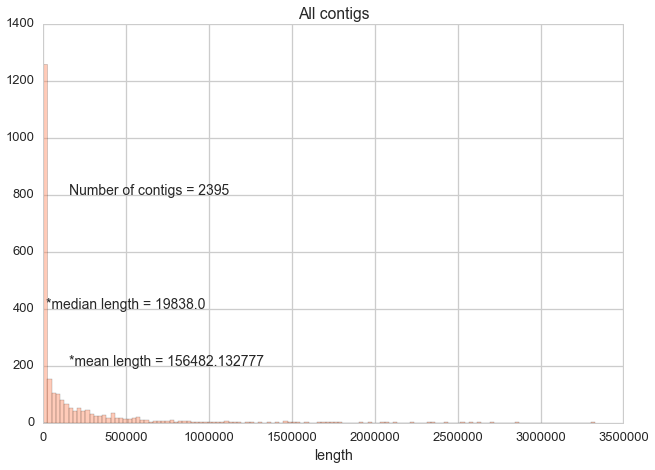

In [21]:
sns.distplot(contig_info.length, color="coral", kde=0);
median_contig_len = contig_info.length.median()
mean_contig_len = contig_info.length.mean()
plt.text(median_contig_len,400,"*median length = {}".format(median_contig_len), fontsize=14);
plt.text(mean_contig_len,200,"*mean length = {}".format(mean_contig_len), fontsize=14);
plt.text(mean_contig_len,800,"Number of contigs = {}".format(len(contig_info)), fontsize=14);
plt.title("All contigs");

### All SNP-pair contigs

In [22]:
sp_contigs = contig_info[contig_info.scaf_name.isin(ld_contig.scaf_name.unique())]
len(sp_contigs)

1276

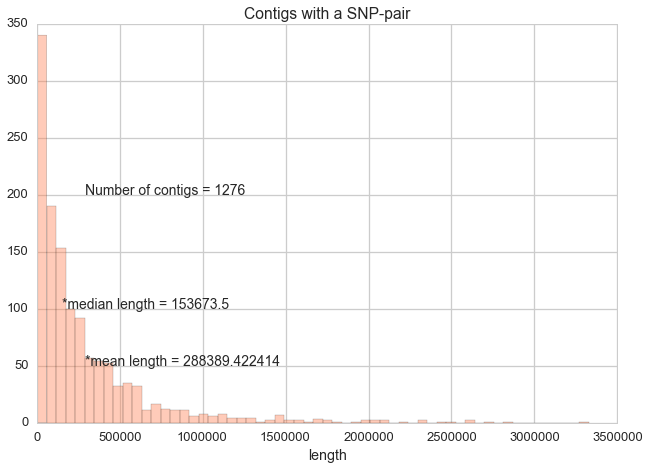

In [23]:
sns.distplot(sp_contigs.length, color="coral", kde=0);
sp_median_contig_len = sp_contigs.length.median()
sp_mean_contig_len = sp_contigs.length.mean()
plt.text(sp_median_contig_len,100,"*median length = {}".format(sp_median_contig_len), fontsize=14);
plt.text(sp_mean_contig_len,50,"*mean length = {}".format(sp_mean_contig_len), fontsize=14);
plt.text(sp_mean_contig_len,200,"Number of contigs = {}".format(len(sp_contigs)), fontsize=14);
plt.title("Contigs with a SNP-pair");

### LD filtered SNP-pair contigs

In [24]:
ld_filt_contigs = ld_contig.query("one_minus_cdf_BH <= 0.01")
ld_filt_contigs = contig_info[contig_info.scaf_name.isin(ld_filt_contigs.scaf_name.unique())]
len(ld_filt_contigs)

547

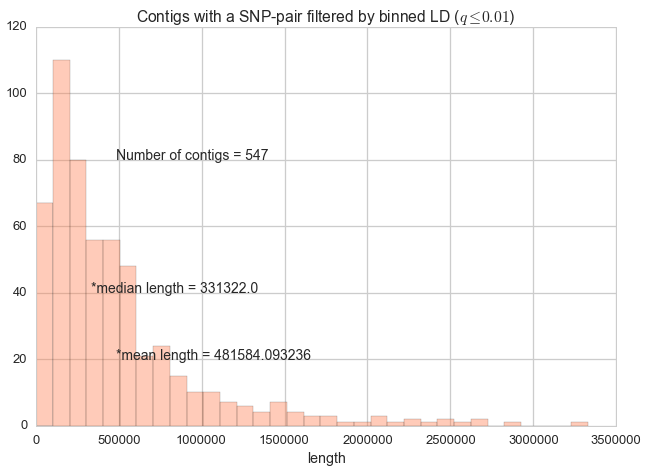

In [25]:
sns.distplot(ld_filt_contigs.length, color="coral", kde=0);
ld_filt_median_contig_len = ld_filt_contigs.length.median()
ld_filt_mean_contig_len = ld_filt_contigs.length.mean()
plt.text(ld_filt_median_contig_len, 40, "*median length = {}".format(ld_filt_median_contig_len), fontsize=14);
plt.text(ld_filt_mean_contig_len, 20, "*mean length = {}".format(ld_filt_mean_contig_len), fontsize=14);
plt.text(ld_filt_mean_contig_len ,80, "Number of contigs = {}".format(len(ld_filt_contigs)), fontsize=14);
plt.title(r"Contigs with a SNP-pair filtered by binned LD ($q \leq 0.01$)");

## Compare with Tajima's D results from AndreaG

In [26]:
taj50.head()

,CHROM,BIN_start,N_SNPs,TajimaD
202,KK351785.1,23400,4,2.35852
8242,KK351785.1,425400,3,2.31422
66484,KK351787.1,68900,2,2.20911
67161,KK351787.1,102750,4,2.90971
67278,KK351787.1,108600,2,2.08884


In [27]:
ld_contig.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,0.114350,0.035591,0.952018,NaN,NaN,0.999063,0.000937,0.073542,False,KK351785.1,Scaffold0,3329503
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17150,0.101013,0.041075,0.215801,NaN,NaN,0.745361,0.254639,0.912914,False,KK351785.1,Scaffold0,3329503


### To accomplish
Need to filter out `ld_contig` data that has either SNP ocurring in the bins defined by `taj50.CHROM:taj50.BIN_start-[taj50.BIN_start+50]`

First try:

- join INNER `ld_contig` and `taj50` on `left_on=kk_name`, `right_on=CHROM` as `ld_contig_taj`
- reatain those rows where `ld_contig_taj.BP_A` or `ld_contig_taj.BP_B` is inside `ld_contig_taj.BIN_start` - `ld_contig_taj.BIN_start+50`

In [28]:
ld_contig_taj = pd.merge(left=ld_contig, right=taj50, how='inner', left_on='kk_name', right_on='CHROM')

In [29]:
def get_taj_win_mask(df):
    taj_win_start = df.BIN_start
    taj_win_end = df.BIN_start + 50
    
    a_mask = (ld_contig_taj.BIN_start <= ld_contig_taj.BP_A) & (ld_contig_taj.BP_A <= ld_contig_taj.BIN_start + 50)
    b_mask = (ld_contig_taj.BIN_start <= ld_contig_taj.BP_B) & (ld_contig_taj.BP_B <= ld_contig_taj.BIN_start + 50)
    
    return (a_mask | b_mask)

# get all at first
ld_contig_taj_win = ld_contig_taj[get_taj_win_mask(ld_contig_taj)]

# now subset these to only rows that meet the LD bin filter
ld_contig_taj_win_filter = ld_contig_taj_win.query("one_minus_cdf_BH <= 0.01")

In [30]:
print len(ld_contig_taj)
print len(ld_contig_taj_win)
print len(ld_contig_taj_win_filter)

3091859
77219
290


In [31]:
ld_contig_taj_win_filter.head(15)

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length,CHROM,BIN_start,N_SNPs,TajimaD
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1,1,1,10020,10000,0.114350,0.035591,0.9995,NaN,NaN,1.000000,1.931342e-07,0.000017,False,KK351785.1,Scaffold0,3329503,KK351785.1,23400,4,2.35852
2,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1,1,1,10030,10000,0.114350,0.035591,0.9995,NaN,NaN,1.000000,1.931342e-07,0.000017,False,KK351785.1,Scaffold0,3329503,KK351785.1,23400,4,2.35852
4,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1,1,1,10033,10000,0.114350,0.035591,0.9995,NaN,NaN,1.000000,1.931342e-07,0.000017,False,KK351785.1,Scaffold0,3329503,KK351785.1,23400,4,2.35852
57902,Scaffold2,1778682,.,0.316327,Scaffold2,1778842,.,0.330189,1,1,1,160,150,0.237923,0.103781,0.9995,NaN,NaN,0.999797,2.028994e-04,0.009739,False,KK351787.1,Scaffold2,2711279,KK351787.1,1778800,3,2.70058
517599,Scaffold95,757658,.,0.311321,Scaffold95,758682,.,0.330000,1,1,1,1024,1000,0.181166,0.077471,0.9995,NaN,NaN,0.999988,1.233784e-05,0.000770,False,KK351880.1,Scaffold95,831224,KK351880.1,758650,3,2.37484
517600,Scaffold95,757658,.,0.311321,Scaffold95,758684,.,0.330000,1,1,1,1026,1000,0.181166,0.077471,0.9995,NaN,NaN,0.999988,1.233784e-05,0.000770,False,KK351880.1,Scaffold95,831224,KK351880.1,758650,3,2.37484
517601,Scaffold95,757658,.,0.311321,Scaffold95,758689,.,0.330000,1,1,1,1031,1000,0.181166,0.077471,0.9995,NaN,NaN,0.999988,1.233784e-05,0.000770,False,KK351880.1,Scaffold95,831224,KK351880.1,758650,3,2.37484
628088,Scaffold148,122921,.,0.349057,Scaffold148,123603,.,0.349057,1,1,1,682,650,0.200111,0.086950,0.9995,NaN,NaN,0.999951,4.937801e-05,0.002337,False,KK351933.1,Scaffold148,626565,KK351933.1,122900,2,2.13192
628120,Scaffold148,122924,.,0.349057,Scaffold148,123603,.,0.349057,1,1,1,679,650,0.200111,0.086950,0.9995,NaN,NaN,0.999951,4.937801e-05,0.002337,False,KK351933.1,Scaffold148,626565,KK351933.1,122900,2,2.13192
631918,Scaffold153,37694,.,0.308511,Scaffold153,44848,.,0.336735,1,1,1,7154,7150,0.118760,0.039424,0.9995,NaN,NaN,1.000000,1.320516e-07,0.000011,False,KK351938.1,Scaffold153,581351,KK351938.1,44800,2,2.06969


## Examine `ld_contig_taj_win_filter` 

### Basic summary table referencing SNP-pairs

In [32]:
ld_contig_taj_win_filter_t1 = pd.pivot_table(ld_contig_taj_win_filter,
                                             index=['scaf_name','BP_A','BP_B','distance_bin'],
                                             fill_value=0,
                                            )
ld_contig_taj_win_filter_t1.head()

BIN_start  BP_DELTA  DP     MAF_A  \
scaf_name    BP_A  BP_B  distance_bin                                      
Scaffold0    13388 23408 10000             23400     10020   1  0.278846   
                   23418 10000             23400     10030   1  0.278846   
                   23421 10000             23400     10033   1  0.278846   
Scaffold1050 18233 24200 5950              21200      5967   1  0.481132   
                   24229 5950              21200      5996   1  0.481132   

                                          MAF_B MAP_succeeded  N_SNPs  R  R2  \
scaf_name    BP_A  BP_B  distance_bin                                          
Scaffold0    13388 23408 10000         0.298077         False       4  1   1   
                   23418 10000         0.298077         False       4  1   1   
                   23421 10000         0.298077         False       4  1   1   
Scaffold1050 18233 24200 5950          0.481132         False       2  1   1   
                   24229 5950          0.481132         False       2  1   1   

                                       R2_scaled_for_B  TajimaD  alpha_param  \
scaf_name    BP_A  BP_B  distance_bin                                          
Scaffold0    13388 23408 10000                  0.9995  2.35852            0   
                   23418 10000                  0.9995  2.35852            0   
                   23421 10000                  0.9995  2.35852            0   
Scaffold1050 18233 24200 5950                   0.9995  2.49245            0   
                   24229 5950                   0.9995  2.49245            0   

                                       beta_param  cdf  distance_bin_mean_R2  \
scaf_name    BP_A  BP_B  distance_bin                                          
Scaffold0    13388 23408 10000                  0    1              0.114350   
                   23418 10000                  0    1              0.114350   
                   23421 10000                  0    1              0.114350   
Scaffold1050 18233 24200 5950                   0    1              0.119299   
                   24229 5950                   0    1              0.119299   

                                       distance_bin_median_R2   length  \
scaf_name    BP_A  BP_B  distance_bin                                    
Scaffold0    13388 23408 10000                       0.035591  3329503   
                   23418 10000                       0.035591  3329503   
                   23421 10000                       0.035591  3329503   
Scaffold1050 18233 24200 5950                        0.042926    42386   
                   24229 5950                        0.042926    42386   

                                       one_minus_cdf  one_minus_cdf_BH  
scaf_name    BP_A  BP_B  distance_bin                                   
Scaffold0    13388 23408 10000          1.931342e-07          0.000017  
                   23418 10000          1.931342e-07          0.000017  
                   23421 10000          1.931342e-07          0.000017  
Scaffold1050 18233 24200 5950           7.267022e-08          0.000007  
                   24229 5950           7.267022e-08          0.000007

### How is q-value related to SNP-pair distance?

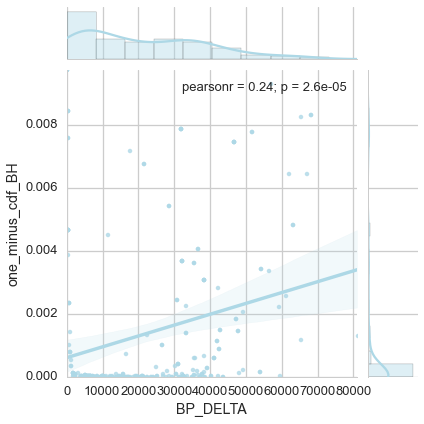

In [33]:
sns.jointplot(x='BP_DELTA',
              y='one_minus_cdf_BH', 
              data=ld_contig_taj_win_filter, 
              kind='reg',
              color='lightblue',
              xlim=(0,ld_contig_taj_win_filter.distance_bin.max()),
              ylim=(0,ld_contig_taj_win_filter.one_minus_cdf_BH.max()));

### What is the distribution of SNPs per bin used for Tajima's D bin_50

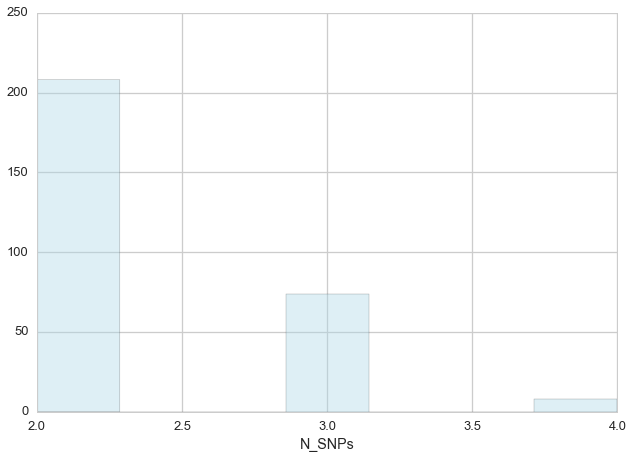

In [34]:
sns.distplot(ld_contig_taj_win_filter.N_SNPs, color='lightblue', kde=0);

### How Tajima's D score bin_50 relate to number of SNPs in the bin

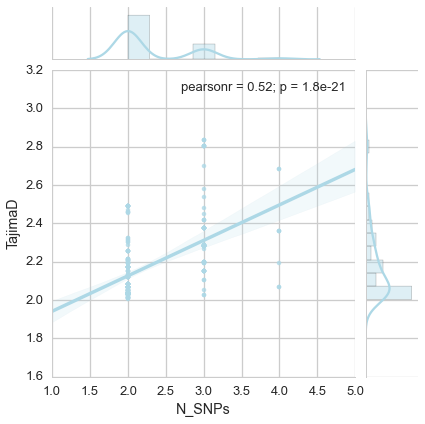

In [35]:
sns.jointplot(x='N_SNPs',
              y='TajimaD', 
              data=ld_contig_taj_win_filter, 
              kind='reg',
              color='lightblue',
             );

# Average LD per bin

### How many contigs are available to each distance_bin?

In [36]:
def get_contigs_per_bin(d_bins,contig_info):
    
    cpb = {}
    
    for b in d_bins:
        cpb[b] = sum(contig_info.length > b)
        
    return pd.Series(cpb)

In [37]:
d_bins = ld_contig.distance_bin.unique()
d_bins.sort()
d_bins
# Generate a dict to map how many contigs avail to each bin
contigs_per_bin = get_contigs_per_bin(d_bins,contig_info)
contigs_per_bin

0         2395
50        2395
100       2395
150       2395
200       2395
250       2395
300       2395
350       2395
400       2395
450       2395
500       2395
550       2395
600       2395
650       2395
700       2395
750       2395
800       2395
850       2395
900       2394
950       2384
1000      2361
1050      2295
1100      2229
1150      2166
1200      2120
1250      2067
1300      2023
1350      1986
1400      1946
1450      1919
          ... 
249350     464
249600     463
250050     463
252400     461
256050     451
256550     449
256650     449
256750     449
257400     449
258050     447
259500     446
259600     446
262100     440
266550     429
267300     429
270750     420
271700     420
275150     416
279350     413
282100     410
282300     409
282550     409
283100     409
285300     405
289700     397
293450     395
310400     379
314800     375
319600     369
334150     354
dtype: int64

In [38]:
contigs_per_bin = pd.DataFrame(contigs_per_bin,columns=['contigs_per_bin'])

In [39]:
contigs_per_bin = contigs_per_bin.reset_index().rename(columns={'index':'distance_bin'}, inplace=False)

In [40]:
contigs_per_bin.head()

,distance_bin,contigs_per_bin
0,0,2395
1,50,2395
2,100,2395
3,150,2395
4,200,2395


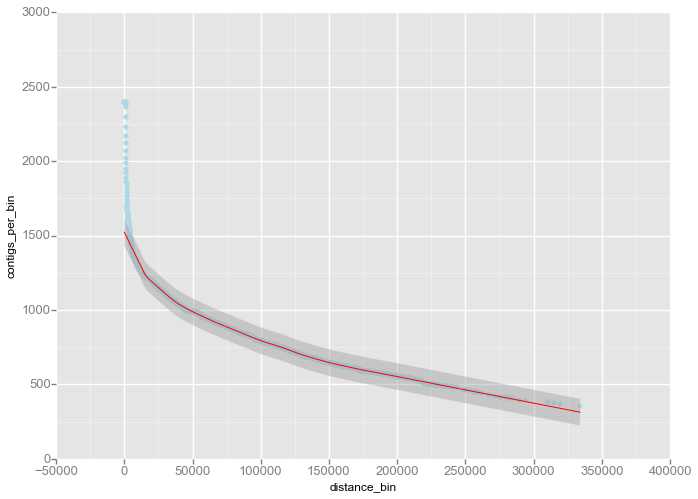

<ggplot: (8750823890857)>

In [41]:
gp.ggplot(gp.aes(x='distance_bin', y='contigs_per_bin'), data=contigs_per_bin) + \
    gp.geom_point(color='lightblue') + \
    gp.stat_smooth(span=.15, color='red', se=True)

## All contigs together

In [42]:
ld_contig.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,0.114350,0.035591,0.952018,NaN,NaN,0.999063,0.000937,0.073542,False,KK351785.1,Scaffold0,3329503
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17150,0.101013,0.041075,0.215801,NaN,NaN,0.745361,0.254639,0.912914,False,KK351785.1,Scaffold0,3329503


In [43]:
mean_bin_r2_all = ld_contig.groupby("distance_bin").mean().reset_index()

In [44]:
median_bin_r2_all = ld_contig.groupby("distance_bin").median().reset_index()

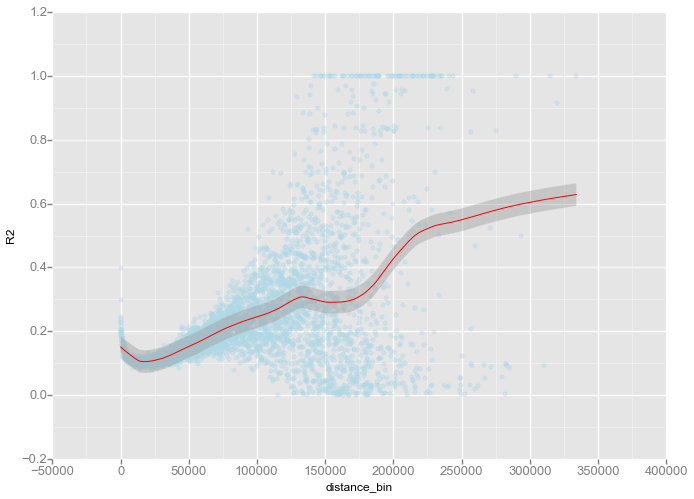

<ggplot: (8750823410793)>

In [45]:
gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin >= 0")) + \
    gp.geom_point(color='lightblue', alpha=0.4) + \
    gp.stat_smooth(span=.15, color='red', se=True)

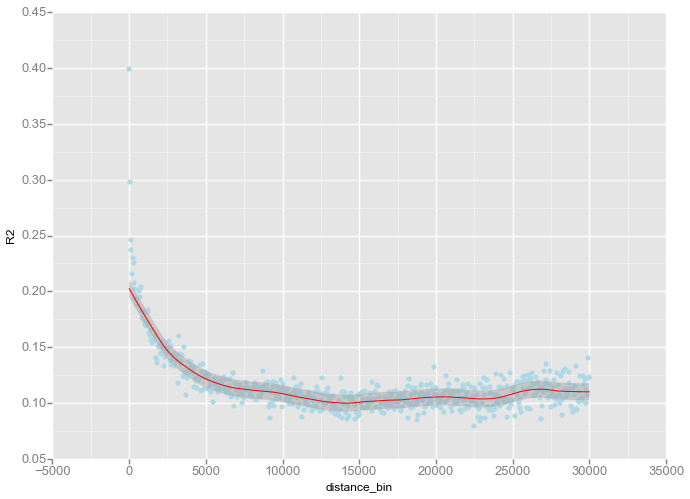

<ggplot: (8750823377769)>

In [46]:
gp.ggplot(gp.aes(x='distance_bin', y='R2'), data=mean_bin_r2_all.query("distance_bin <= 30000")) + \
    gp.geom_point(color='lightblue') + \
    gp.stat_smooth(span=0.15, color='red', se=True) 

In [47]:
len(ld_contig)

606395

In [48]:
len_contigs_per_bin = ld_contig.pivot_table(index=['distance_bin'], 
                                            values=['scaf_name'],
                                            aggfunc=[len]
                                           )['len'].reset_index()

len_contigs_per_bin = len_contigs_per_bin.rename(columns={'scaf_name':'SNP-pairs'}, inplace=False)
len_contigs_per_bin.head()

,distance_bin,SNP-pairs
0,0,36566
1,50,4273
2,100,1999
3,150,1200
4,200,1155


In [49]:
len_contigs_per_bin.

SyntaxError: invalid syntax (<ipython-input-49-52825ff5b6c9>, line 1)

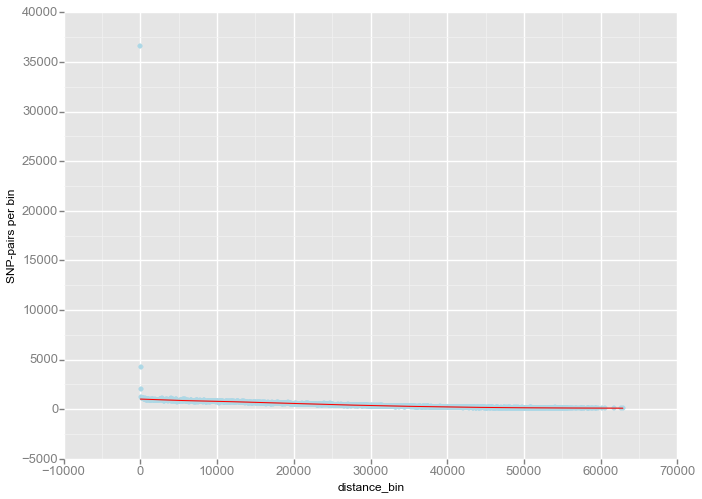

<ggplot: (8750823502237)>

In [58]:
sp_gt100mask = len_contigs_per_bin["SNP-pairs"] > 100

gp.ggplot(gp.aes(x='distance_bin', y='SNP-pairs'), data=len_contigs_per_bin[sp_gt100mask]) + \
    gp.geom_point(color='lightblue') + \
    gp.stat_smooth(span=.15, color='red', se=True) + gp.ylab('SNP-pairs per bin')

,distance_bin,SNP-pairs
0,0,36566
1,50,4273
2,100,1999
3,150,1200
4,200,1155


In [56]:
ld_contig.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,distance_bin_mean_R2,distance_bin_median_R2,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,0.114350,0.035591,0.999500,NaN,NaN,1.000000,0.000000,0.000017,False,KK351785.1,Scaffold0,3329503
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,0.114350,0.035591,0.952018,NaN,NaN,0.999063,0.000937,0.073542,False,KK351785.1,Scaffold0,3329503
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17150,0.101013,0.041075,0.215801,NaN,NaN,0.745361,0.254639,0.912914,False,KK351785.1,Scaffold0,3329503


In [57]:
d_bin_v_others = ld_contig.pivot_table(index=['distance_bin'], 
                                        values=['R2','one_minus_cdf_BH'],
                                        aggfunc=[np.mean]
                                       )['mean'].reset_index()
d_bin_v_others.head()

,distance_bin,R2,one_minus_cdf_BH
0,0,0.399450,0.796507
1,50,0.297822,0.887113
2,100,0.245775,0.917844
3,150,0.237121,0.923097
4,200,0.215979,0.908703


In [58]:
d_bin_v_others = d_bin_v_others.merge(right=len_contigs_per_bin, 
                     how='inner', 
                     on='distance_bin'
                     ).merge(right=contigs_per_bin, 
                             how='inner', 
                             on='distance_bin'
                            )
d_bin_v_others.head()

,distance_bin,R2,one_minus_cdf_BH,SNP-pairs,contigs_per_bin
0,0,0.399450,0.796507,36566,2395
1,50,0.297822,0.887113,4273,2395
2,100,0.245775,0.917844,1999,2395
3,150,0.237121,0.923097,1200,2395
4,200,0.215979,0.908703,1155,2395


In [59]:
d_bin_v_others_melt = pd.melt(d_bin_v_others, id_vars=['distance_bin'])

In [81]:
d_bin_v_others_melt.head()

,distance_bin,variable,value
0,0,R2,0.399450
1,50,R2,0.297822
2,100,R2,0.245775
3,150,R2,0.237121
4,200,R2,0.215979


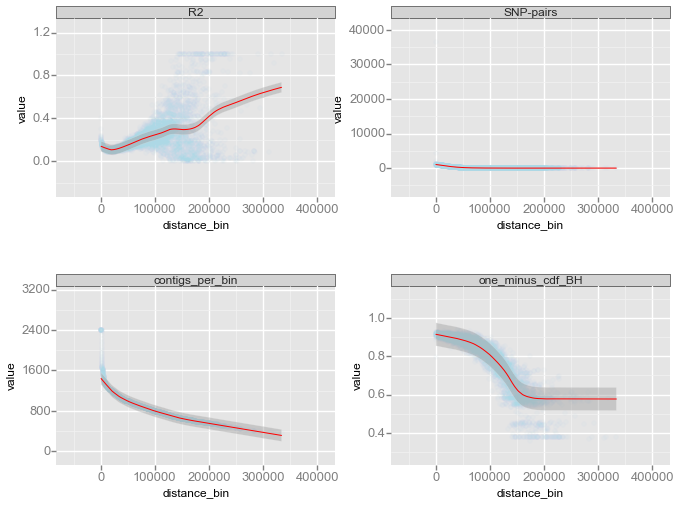

<ggplot: (8789761318269)>

In [84]:
xmin = 0
xmax = 100000000000
gp.ggplot(gp.aes(x='distance_bin', y='value'), 
          data=d_bin_v_others_melt.query("{xmin} <= distance_bin <= {xmax}".format(xmin=xmin,
                                                                                   xmax=xmax
                                                                                  ))) + \
    gp.geom_point(color='lightblue', alpha=0.06) + \
    gp.stat_smooth(span=0.2, color='red', se=True)  + \
    gp.facet_wrap("variable")

In [61]:
# g = sns.PairGrid(d_bin_v_others.loc[:,["R2", "one_minus_cdf_BH",    "SNP-pairs",   "contigs_per_bin",]])
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_diag(sns.kdeplot, lw=3, legend=False)
d_bin_vars = d_bin_v_others.loc[:,["R2", "one_minus_cdf_BH",    "SNP-pairs",   "contigs_per_bin",]]

In [62]:
d_bin_vars.head()

,R2,one_minus_cdf_BH,SNP-pairs,contigs_per_bin
0,0.399450,0.796507,36566,2395
1,0.297822,0.887113,4273,2395
2,0.245775,0.917844,1999,2395
3,0.237121,0.923097,1200,2395
4,0.215979,0.908703,1155,2395


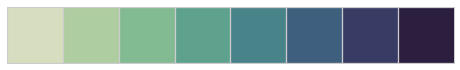

In [63]:
sns.palplot(sns.cubehelix_palette(8, start=.5, rot=-.75))

In [64]:
my_cmap=sns.cubehelix_palette(40, start=.5, rot=-.75, as_cmap=True)
cc = sns.mpl.colors.ColorConverter()
marginal_color = cc.to_rgb(arg=my_cmap.colors[int(255*1)])

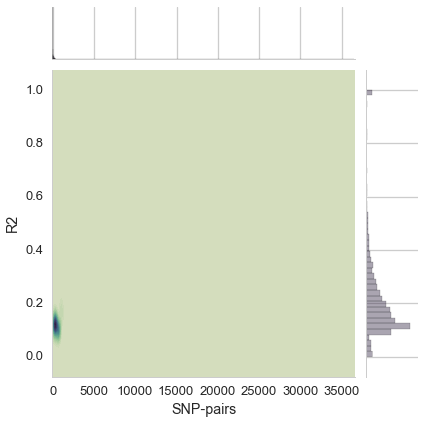

In [65]:
# sns.jointplot('SNP-pairs','R2',d_bin_vars, kind='kde',
#               joint_kws=dict(shade=True,
#                              cmap=my_cmap,
#                              n_levels=40
#                             ),
#               marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
#              )

g = sns.JointGrid('SNP-pairs','R2',d_bin_vars)
g.plot_marginals(sns.distplot, kde=False, color=marginal_color)
g.plot_joint(sns.kdeplot, shade=True, cmap=my_cmap, n_levels=40);

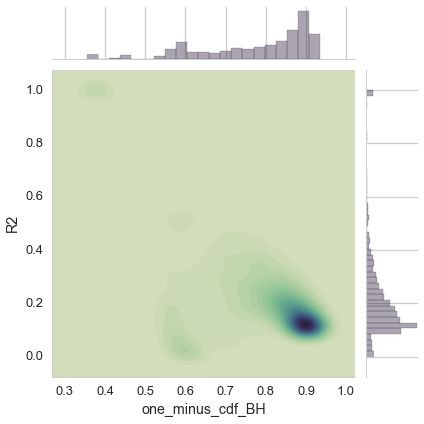

In [66]:
# sns.jointplot('one_minus_cdf_BH','R2',d_bin_vars, kind='kde',
#               joint_kws=dict(shade=True,
#                              cmap=my_cmap,
#                              n_levels=40
#                             ),
#               marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
#              )

g = sns.JointGrid('one_minus_cdf_BH','R2',d_bin_vars)
g.plot_marginals(sns.distplot, kde=False, color=marginal_color)
g.plot_joint(sns.kdeplot, shade=True, cmap=my_cmap, n_levels=40, alpha=1);

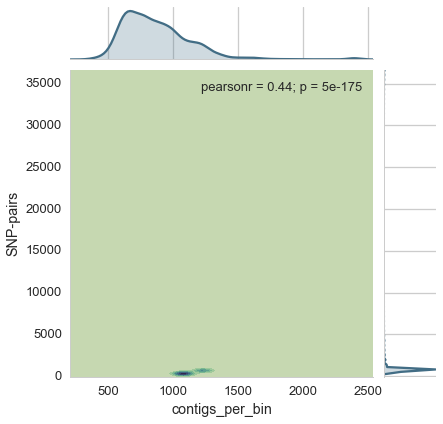

In [70]:
sns.jointplot('contigs_per_bin','SNP-pairs',d_bin_vars, kind='kde',
              joint_kws=dict(shade=True,
                             cmap=my_cmap,
                             n_levels=8
                            ),
              marginal_kws=dict(shade=True, color=my_cmap.colors[int(256*0.66)])
             )

## 5 random contigs